# Определение возраста покупателей по фото

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая приблизительно определит возраст покупателя. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
print(labels['real_age'].value_counts().count())

97


* Размер выборки составляет 7591 элементов, уникальных возрастов 97. Этих данных должно хватить для точного определения возраста.

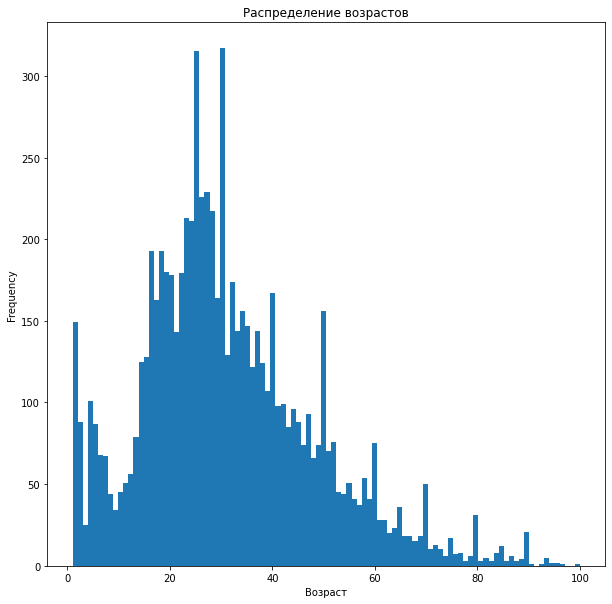

In [4]:
plt.figure(figsize=(10,10))
labels['real_age'].plot(kind='hist', bins=100)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.show()

In [5]:
display(labels['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

* Возраст варьируется от 1 до 100 лет. Медиана составляет 29 лет, среднее - 31. Основная часть фото распределена в возрасте 10-50 лет. Распределение имеет длинный правый хвост. Заметны всплески в юбилейные годы (кратные 0, 10, 20 и т.д.). Вероятно, это связано с некачественной разметкой данных.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
features, target = next(train_gen_flow)

Found 7591 validated image filenames.


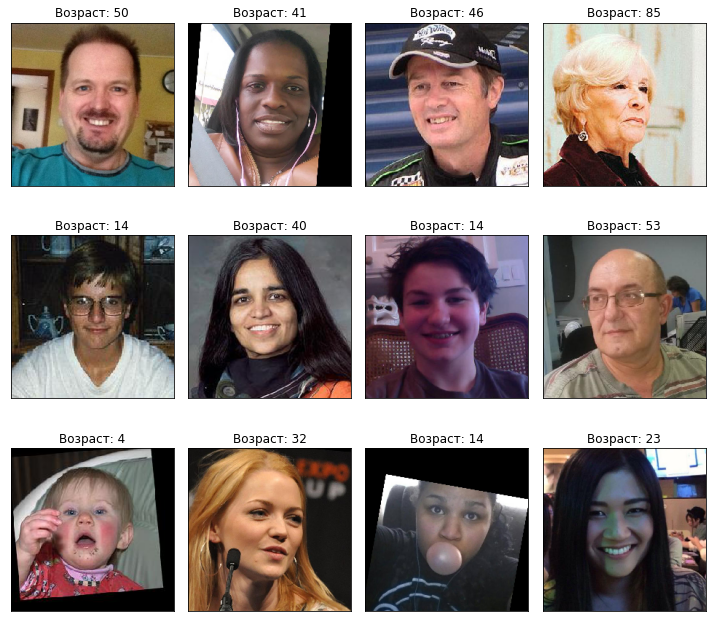

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()  
plt.show()

Изображения представляют собой лица крупным планом разных полов и возрастов. Во многих фото есть следующие особенности:
* Наличие посторонних предметов (микрофон, жвачка, бижутерия)
* Фото, повернутые под неправильным углом (отклонение не более 30° от правильного положения)
* Черно-белые фото
* Различные ракурсы, в т.ч. в профиль
* Различное качество фотографий, есть и профессиональные (правильное освещение, ракурс и четкость изображения) и некачественные (снятые на веб-камеру с низким разрешением).

Для данного набора можно применить следующие аугументации:
* Вращение не более, чем на 30°
* Горизонтальное отражение
* Вертикальные и горизонтальные сдвиги
* Изменение яркости фото
* Изменение масштаба 


## Обучение модели

**Обучаем и тестируем нейросеть ResNet50**

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory= path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345) 
    features_train, target_train = next(train_gen_flow)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory= path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345) 
    features_test, target_test = next(test_gen_flow)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer= Adam(0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Epoch 1/10
178/178 - 67s - loss: 243.2316 - mean_absolute_error: 11.0043 - val_loss: 902.4108 - val_mean_absolute_error: 25.1984
Epoch 2/10
178/178 - 37s - loss: 60.2375 - mean_absolute_error: 5.8559 - val_loss: 364.6911 - val_mean_absolute_error: 14.1695
Epoch 3/10
178/178 - 37s - loss: 31.3305 - mean_absolute_error: 4.3066 - val_loss: 358.5453 - val_mean_absolute_error: 14.2406
Epoch 4/10
Epoch 5/10
178/178 - 37s - loss: 19.6056 - mean_absolute_error: 3.4048 - val_loss: 103.5495 - val_mean_absolute_error: 7.7180
178/178 - 37s - loss: 14.4810 - mean_absolute_error: 2.9399 - val_loss: 94.9138 - val_mean_absolute_error: 7.3657
Epoch 6/10
178/178 - 37s - loss: 11.5943 - mean_absolute_error: 2.6320 - val_loss: 65.1682 - val_mean_absolute_error: 6.1738
Epoch 7/10
178/178 - 37s - loss: 10.3453 - mean_absolute_error: 2.4956 - val_loss: 104.4948 - val_mean_absolute_error: 8.2585
Epoch 8/10
178/178 - 37s - loss: 10.0652 - mean_absolute_error: 2.3909 - val_loss: 81.9697 - val_mean_absolute_error: 6.7361
Epoch 9/10
178/178 - 37s - loss: 9.7725 - mean_absolute_error: 2.3662 - val_loss: 70.0360 - val_mean_absolute_error: 6.4188
Epoch 10/10
178/178 - 37s - loss: 8.2069 - mean_absolute_error: 2.1414 - val_loss: 63.6118 - val_mean_absolute_error: 6.0136
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 63.6118 - mean_absolute_error: 6.0136
Test MAE: 6.0136

```

## Анализ обученной модели

Задачей проекта было построить модель, определяющую возраст по фото для следующих целей:

1) Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

2) Контролировать добросовестность кассиров при продаже алкоголя.

По итогу проекта обучили нейросеть архитектуры ResNet50, в качестве финального слоя выбрали полносвязный слой с 1 нейроном и ReLu - активацией. Использовали предобученные веса ImageNet. Обучение модели проводили при следующих параметрах: размер батча 32, оптимизатор Adam со скоростью обучения 0.0001, 10 эпох, без заморозки весов.


Среднее абсолютное отклонение на обучающей выборке получили 2.1414, на тестовой 6.0136. Т.к. качество предсказаний отличается почти в 3 раза, модель переобучена. Однако достигнутое качество соответствует требованиям.

Модель отлично подойдет для выполнения первой задачи, т.к. для определения возрастной категории ее точности достаточно.

При определении права на покупку алкоголя модель неидеальна в случае молодых людей и подростков. Например, она может завысить возраст несовершеннолетнего подростка и посчитать, что он имеет право покупать алкоголь. Точно так же модель может занизить возраст совершеннолетних покупателей. В случае взрослых старше 25 и детей точности модели будет достаточно.
